## LIBRARY IMPORTS

In [1]:
import datetime as dt
import glob
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import TimeDistributed, Dense, LSTM, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import TensorBoard

# setting random seed
random.seed(1994)

2022-11-29 17:27:55.287426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 17:27:55.570784: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-29 17:27:55.626949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 17:27:55.626964: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## DATA VISUALIZATION

In [2]:
# load data from csv files
dfs = {
    path.split("/")[-1].replace(".csv", ""): pd.read_csv(path)
    for path in glob.glob("dataset_air_quality/*")
}

In [3]:
# data columns
ts_cols = ["pm25", "pm10", "o3", "no2", "so2", "co"]

# formatting of data
for name, df in dfs.items():
    df.columns = [c.strip() for c in df.columns]
    df["date"] = pd.to_datetime(df["date"])
    
    for val in ts_cols:
        df[val] = df[val].apply(lambda x: float(x) if str(x).strip().isnumeric() else np.nan)

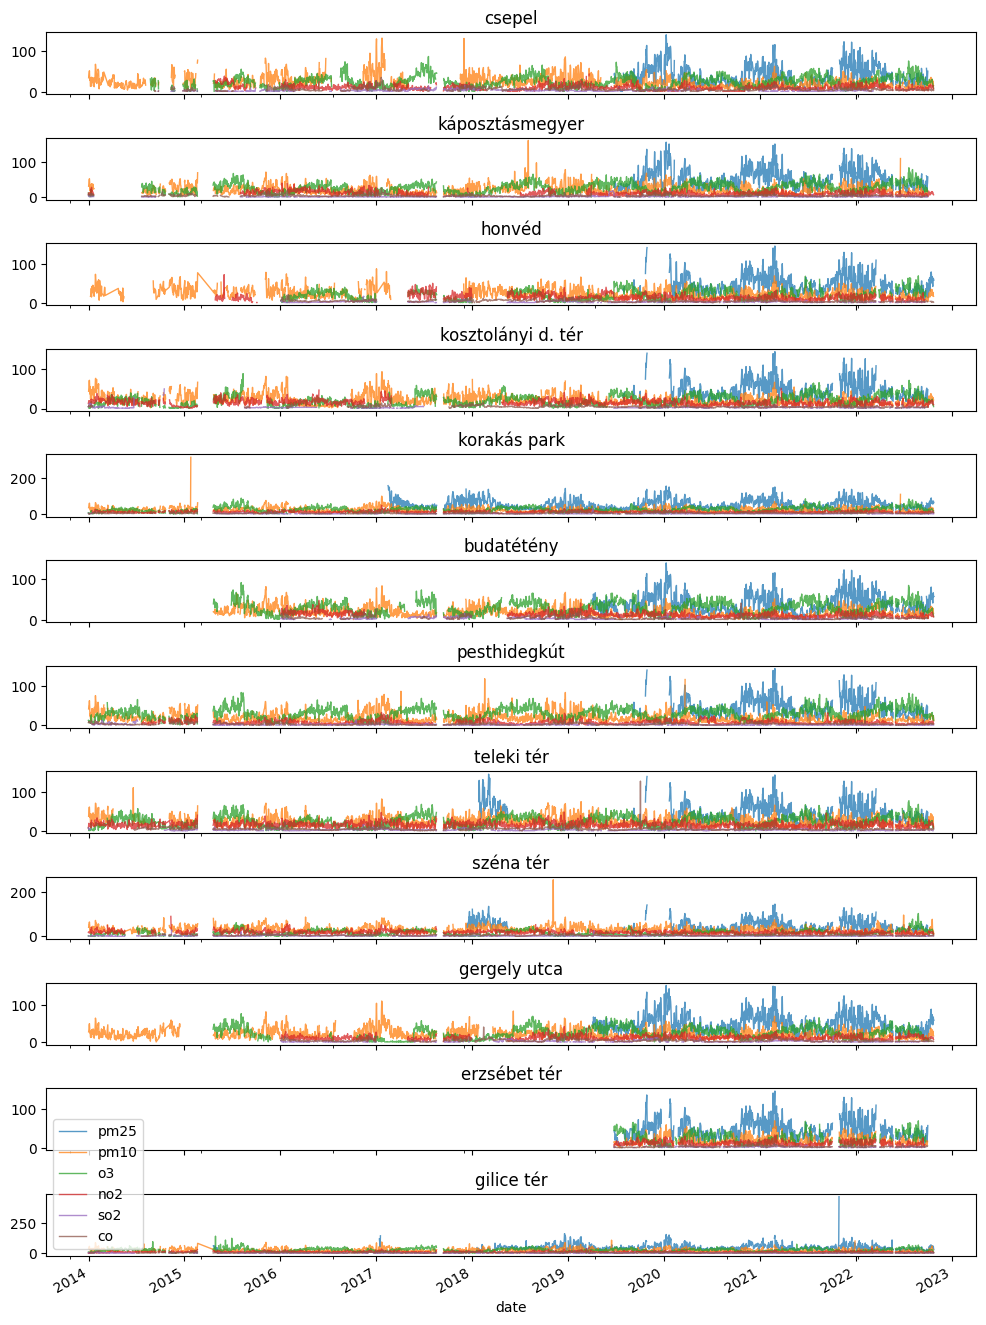

In [4]:
# data visualization
fig, axs = plt.subplots(len(dfs), 1, sharex=True)
fig.set_figwidth(12)
fig.set_figheight(18)
fig.subplots_adjust(hspace=0.7)
for idx, (name, df) in enumerate(dfs.items()):
    df.plot(x="date", alpha=0.75, linewidth=1, ax=axs[idx], legend=(idx == len(dfs)-1), title=name)

## DATA EXPLORATION

<AxesSubplot: >

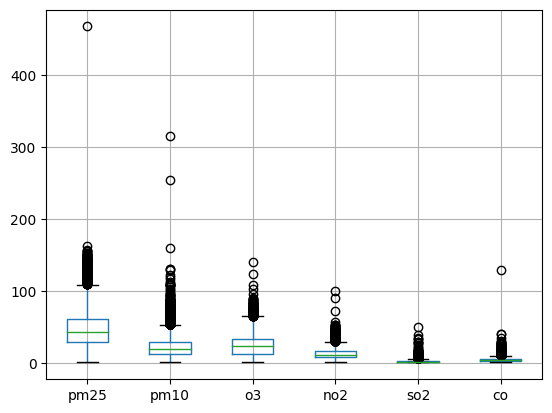

In [5]:
# boxplot of each column data
dff = pd.concat([df[ts_cols] for _, df in dfs.items()])
dff.boxplot()

In [6]:
# 95% percentile of the columns
quant = dff.quantile([0.95])
quant

,pm25,pm10,o3,no2,so2,co
0.95,96.0,48.0,49.0,25.0,5.0,10.0


## FEATURE CALCULATION

<AxesSubplot: xlabel='date'>

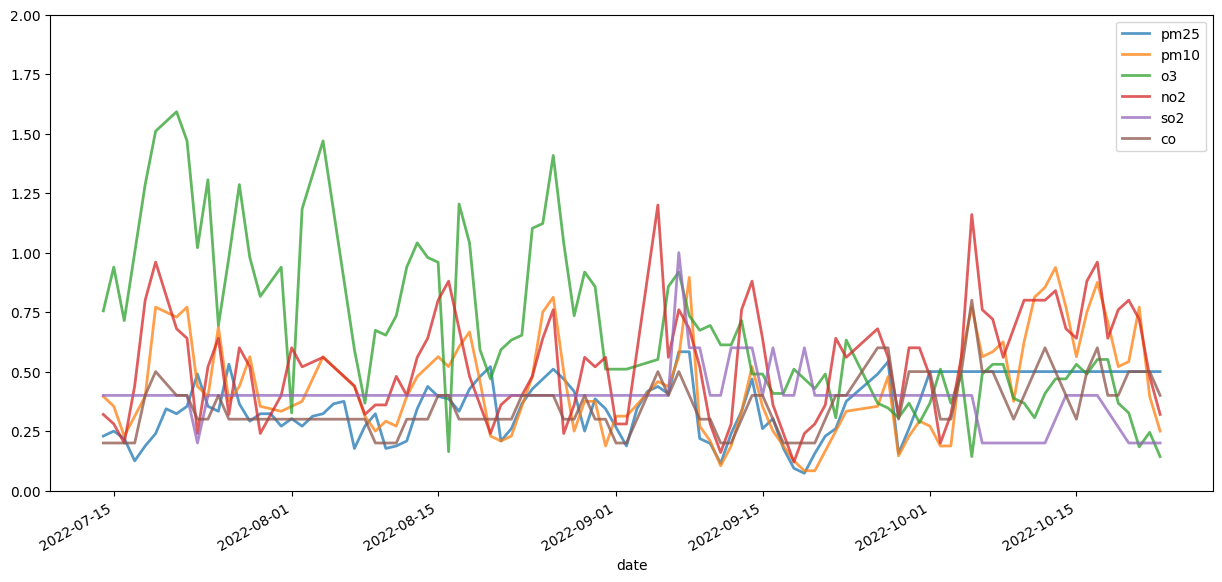

In [7]:
df = dfs["teleki tér"].sort_values(by="date").iloc[-100:].copy()

# scale down
df[ts_cols] = df[ts_cols]/quant.loc[0.95]

# interpolate
df[ts_cols] = df[ts_cols].interpolate(method="linear")

df.plot(x="date", alpha=0.75, linewidth=2, figsize=(15, 7), ylim=(0,2))

In [8]:
df_features_list = []
df_features_test = pd.DataFrame()

for idx, (_, df) in enumerate(dfs.items()):
    df_tmp = pd.DataFrame()
    
    # scale down and interpolate
    df_tmp[ts_cols] = df.sort_values(by="date")[ts_cols]/quant.loc[0.95]
    df_tmp[ts_cols] = df_tmp[ts_cols].interpolate(method="linear")
    
    # add station number
    df_tmp["station"] = df.apply(lambda x: idx, axis=1)
    
    # separate samples for testing
    if idx==0:
        df_features_test = df_tmp.iloc[-365:].reset_index()
        df_features_list.append(df_tmp.iloc[:-365])
    else:
        df_features_list.append(df_tmp)
    
df_features = pd.concat(df_features_list, ignore_index=True)

df_final = df_features.fillna(-1)
df_final_test = df_features_test.fillna(-1)
df_final

,pm25,pm10,o3,no2,so2,co,station
0,-1.000000,0.708333,-1.000000,-1.00,-1.0,-1.0,0
1,-1.000000,0.833333,-1.000000,-1.00,-1.0,-1.0,0
2,-1.000000,0.937500,-1.000000,-1.00,-1.0,-1.0,0
3,-1.000000,1.062500,-1.000000,-1.00,-1.0,-1.0,0
4,-1.000000,0.666667,-1.000000,-1.00,-1.0,-1.0,0
...,...,...,...,...,...,...,...
33603,0.468750,0.458333,0.408163,0.52,0.6,0.3,11
33604,0.458333,0.666667,0.285714,0.48,0.6,0.3,11
33605,0.604167,0.666667,0.346939,0.24,0.4,0.4,11
33606,0.406250,0.666667,0.183673,0.20,0.4,0.4,11


In [9]:
timesteps = 7

In [10]:
xs, ys = [], []

# creation of training arrays
for stn_id in range(12):
    df_stn = df_final[df_final["station"] == stn_id]
    for idx in range(len(df_stn) - timesteps):
        df_seq = df_stn.iloc[idx:idx + (timesteps + 1)].drop(columns="station")
        df_x = df_seq.iloc[:-1]
        df_y = df_seq.iloc[-1][ts_cols]
        xs.append(df_x.values)
        ys.append(df_y.values)

# shuffle training data
xsys = list(zip(xs, ys))
random.shuffle(xsys)
xs, ys = zip(*xsys)

X = np.array(xs, dtype=float)
Y = np.array(ys, dtype=float)

## MODEL ARCHITECTURE

In [11]:
batch_size = 32
epochs = 20

INPUT_LEN = 6
OUTPUT_LEN = 6

# define model architecture with lstm layer and dense layer
model = Sequential()
model.add(LSTM(16, input_shape=(timesteps, INPUT_LEN), return_sequences=False))
# model.add(LSTM(16, input_shape=(timesteps, INPUT_LEN), return_sequences=True))
model.add(Dense(OUTPUT_LEN))
# model.add(TimeDistributed(Dense(OUTPUT_LEN)))
model.compile(optimizer="adam", loss="mse")
model.summary()

2022-11-29 17:28:16.307347: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-29 17:28:16.307516: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-29 17:28:16.307531: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jaimeteb-dell): /proc/driver/nvidia/version does not exist
2022-11-29 17:28:16.308125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1472      
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
Total params: 1,574
Trainable params: 1,574
Non-trainable params: 0
_________________________________________________________________


## TRAINING

In [12]:
now = dt.datetime.now().isoformat()

# fit model with validation split and tensorboard logging
hist = model.fit(
    x=X,
    y=Y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[TensorBoard(
        f"./logs/{now}",
        update_freq=1,
        write_images=True,
    )],
)

Epoch 1/20
943/943 [==============================] - 4s 3ms/step - loss: 0.0820 - val_loss: 0.0325
Epoch 2/20
943/943 [==============================] - 2s 2ms/step - loss: 0.0287 - val_loss: 0.0250
Epoch 3/20
943/943 [==============================] - 2s 2ms/step - loss: 0.0249 - val_loss: 0.0235
Epoch 4/20
943/943 [==============================] - 2s 2ms/step - loss: 0.0238 - val_loss: 0.0228
Epoch 5/20
943/943 [==============================] - 2s 2ms/step - loss: 0.0233 - val_loss: 0.0226
Epoch 6/20
943/943 [==============================] - 2s 2ms/step - loss: 0.0230 - val_loss: 0.0223
Epoch 7/20
943/943 [==============================] - 2s 3ms/step - loss: 0.0228 - val_loss: 0.0228
Epoch 8/20
943/943 [==============================] - 2s 2ms/step - loss: 0.0227 - val_loss: 0.0221
Epoch 9/20
943/943 [==============================] - 2s 2ms/step - loss: 0.0225 - val_loss: 0.0220
Epoch 10/20
943/943 [==============================] - 2s 3ms/step - loss: 0.0224 - val_loss: 0.0221

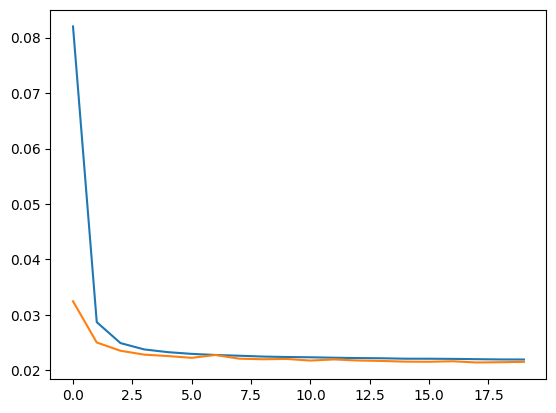

In [13]:
# loss visualization
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

## TESTING

In [14]:
# creation of test arrays
xs_true, ys_true = [], []
for idx in range(len(df_final_test) - timesteps):
    df_seq = df_final_test.iloc[idx:idx+(timesteps+1)].drop(columns=["station", "index"])
    df_x_true = df_seq.iloc[:-1]
    df_y_true = df_seq.iloc[-1][ts_cols]
    xs_true.append(df_x_true.values)
    ys_true.append(df_y_true.values)

x_true = np.array(xs_true, dtype=float)
y_true = np.array(ys_true, dtype=float)

In [15]:
# model predictions
y_pred = model.predict(x_true)
df_y_pred = pd.DataFrame(data=y_pred, columns=ts_cols)
df_y_true = pd.DataFrame(data=y_true, columns=ts_cols)

12/12 [==============================] - 0s 2ms/step


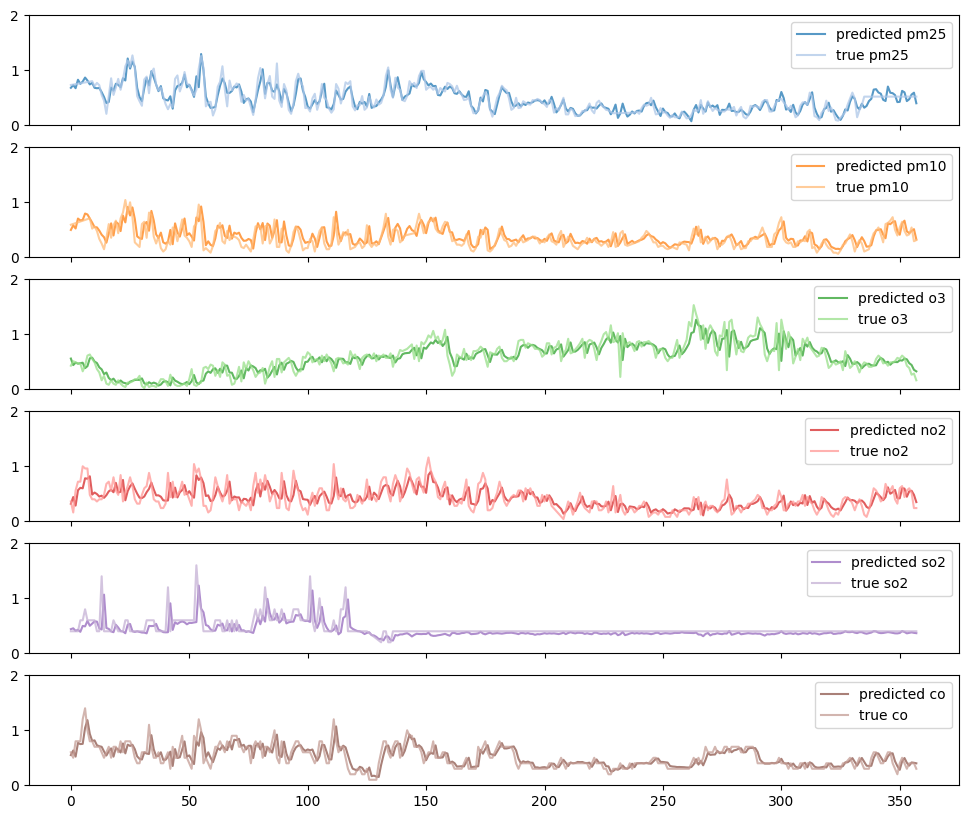

In [16]:
# visualize predictions
fig, axs = plt.subplots(6, 1, sharex=True)
fig.set_figwidth(12)
fig.set_figheight(10)
colors = iter([plt.cm.tab20(i) for i in range(20)])
for idx, col in enumerate(ts_cols):
    df_y_pred[[col]].plot(ax=axs[idx], alpha=0.75, ylim=(0,2), color=next(colors))
    df_y_true[[col]].plot(ax=axs[idx], alpha=0.75, ylim=(0,2), color=next(colors))
    axs[idx].legend([f"predicted {col}", f"true {col}"])

In [17]:
y_true_2 = y_true.copy()[:-100]

for i in range(100):
    y_true_2 = np.append(
        y_true_2,
        model.predict(y_true_2[-timesteps:].reshape(1,timesteps,INPUT_LEN), verbose=False),
        axis=0
    )
    
df_y_true_2 = pd.DataFrame(data=y_true_2, columns=ts_cols)

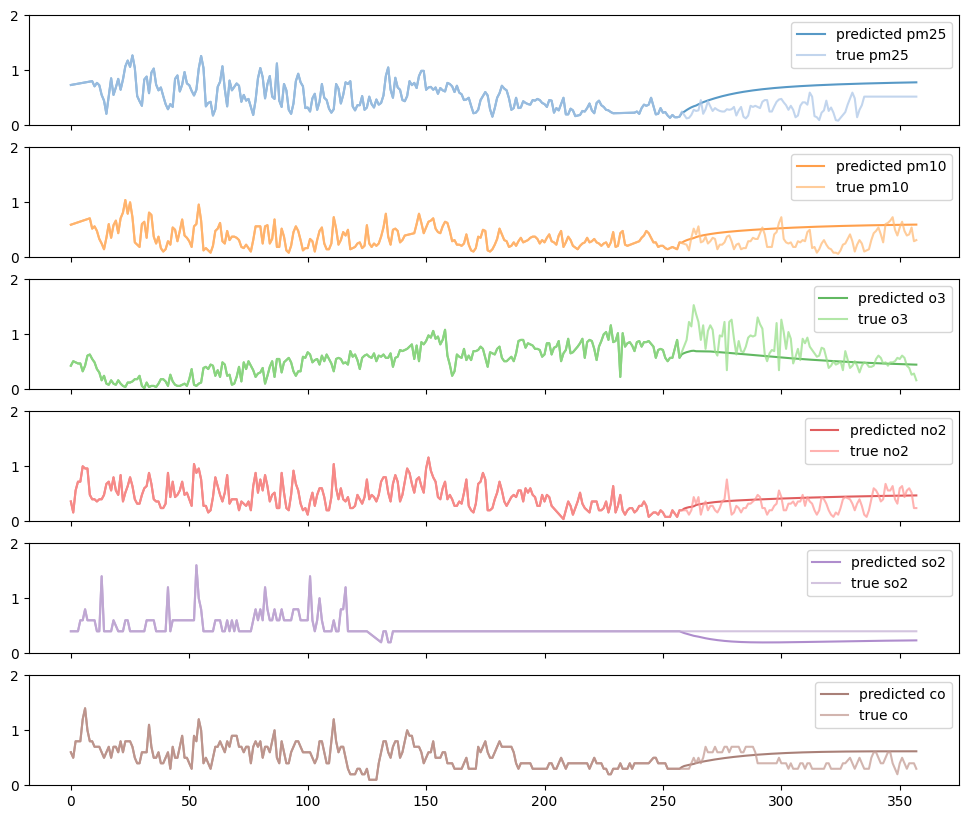

In [18]:
# visualize predictions
fig, axs = plt.subplots(6, 1, sharex=True)
fig.set_figwidth(12)
fig.set_figheight(10)
colors = iter([plt.cm.tab20(i) for i in range(20)])
for idx, col in enumerate(ts_cols):
    df_y_true_2[[col]].plot(ax=axs[idx], alpha=0.75, ylim=(0,2), color=next(colors))
    df_y_true[[col]].plot(ax=axs[idx], alpha=0.75, ylim=(0,2), color=next(colors))
    axs[idx].legend([f"predicted {col}", f"true {col}"])

In [21]:
model.save(f"./model/model.h5")

quant_json = quant.loc[0.95].to_dict()
json.dump(quant_json, open("./model/quant.json", "w"))